<img src='https://greenedge-itn.eu/wp-content/uploads/2021/02/logo.png' height=100> **CHALLENGE**


---



#EfficientNet Example

<!-- <img src='https://greenedge-itn.eu/wp-content/uploads/2021/03/green-edge-mascotte.png' height=150> -->

This notebook, which complements the challenge description document, details how energy consumption should be estimated, and how each submission to the challenge will be scored. The procedure is illustrated on an example.

## Install Requirements
Install the following libraries
- **Deep Lake** (https://github.com/activeloopai/deeplake?tab=readme-ov-file): Deep Lake is a Database for AI powered by a storage format optimized for deep-learning applications.

- **fvcore** (https://github.com/facebookresearch/fvcore): a light-weight core library that provides the most common and essential functionality shared in various computer vision frameworks developed by the Fundamental AI Research (FAIR) team at Meta. For this challenge, you will need the flop counter documented [here](https://github.com/facebookresearch/fvcore/blob/main/docs/flop_count.md).

<!-- - **TorchMetrics** (https://github.com/Lightning-AI/torchmetrics): TorchMetrics is a collection of 100+ PyTorch metrics implementations and an easy-to-use API to create custom metrics. For this challenge, you will need it for the computation of models' accuracy. -->

In [ ]:
!pip install deeplake
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.6/586.6 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56

## TinyImageNet Dataset (Deep Lake)
Download and prepare the TinyImageNet dataset using *Deep Lake*. The test queue is called *validation* data.

<img src='https://datasets.activeloop.ai/wp-content/uploads/2022/09/tinyimagenet-dataset-Activeloop-Platform-visualization-image-1024x446.webp' height=250>



In [ ]:
import deeplake
from torchvision import transforms

train_data = deeplake.load("hub://activeloop/tiny-imagenet-train")
validation_data = deeplake.load("hub://activeloop/tiny-imagenet-validation")

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-train



-

hub://activeloop/tiny-imagenet-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-validation



|

hub://activeloop/tiny-imagenet-validation loaded successfully.



## EfficientNet Evaluation

<figure>
    <img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_10.45.54_PM.png' height=300>
    <figcaption>Tan, Mingxing, and Quoc Le. "EfficientNet: Rethinking model scaling for convolutional neural networks." International conference on machine learning. PMLR, 2019</figcaption>
</figure>

A submission to this challenge should consist in a set of models $$m_1, \dots, m_R.$$

As an example, we consider the family of EfficientNet models (https://arxiv.org/abs/1905.11946) EfficientNet-B0, ..., EfficientNet-B7 (i.e. $R=8$), and we will estimate the average *energy consumption* values and the *accuracy* values over the test set
$$
    E(m_1), \dots, E(m_R) \quad A(m_1), \dots, A(m_R).
$$
<!-- How to **estimate the energy consumption** via the *fvcore* library., An example for the usage of the *fvcore* library, to estimate the number of FLOPs. -->

For simplicity, we use weights of the EffficientNet models obtained from training on the ImageNet dataset. Due to a current problem with the loading of pretrained weights, we override `torchvision.models._api.WeightsEnum.get_state_dict()`. Please see https://github.com/pytorch/vision/issues/7744#issuecomment-1757321451 for more information.

In [ ]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

We then import relevant packages and prepare the pre-processing step.

In [ ]:
import numpy as np
import torch, warnings, torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
from torchvision.models import efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3, efficientnet_b4, efficientnet_b5, efficientnet_b6, efficientnet_b7
from torchvision.models import EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights, EfficientNet_B3_Weights, EfficientNet_B4_Weights, EfficientNet_B5_Weights, EfficientNet_B6_Weights, EfficientNet_B7_Weights

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)

resolution_dict = {
    "efficientnet_b0": {"resize_size": 256, "crop_size": 224},
    "efficientnet_b1": {"resize_size": 256, "crop_size": 240},
    "efficientnet_b2": {"resize_size": 288, "crop_size": 288},
    "efficientnet_b3": {"resize_size": 320, "crop_size": 300},
    "efficientnet_b4": {"resize_size": 384, "crop_size": 380},
    "efficientnet_b5": {"resize_size": 456, "crop_size": 456},
    "efficientnet_b6": {"resize_size": 528, "crop_size": 528},
    "efficientnet_b7": {"resize_size": 600, "crop_size": 600}
}

def tiny_image_net_transform(tform):
    '''
    Return a Callable which first Cconvert any grayscale images to RGB and then apply
    the composition of transformations specified by `tform`.
    '''

    def tin_transform(sample_in):
        # Convert any grayscale images to RGB
        image = sample_in['images']
        shape = image.shape
        if shape[2] == 1:
            image = np.repeat(image, int(3/shape[2]), axis = 2)
        return {'images': tform(image), 'labels': sample_in['labels']}

    return tin_transform

# Hide potential warnings from fvcore. They may slow down the inference process.
import logging
logging.basicConfig(filename='app.log',
    level=logging.CRITICAL,
    force=True,
)

Device: cuda


The following code computes the average accuracy and average energy consumption -in GFLOPs- of each model over the test set, and stores them in lists ```efficientnet_accuracies``` and ```efficientnet_flops```.  Except for the pre-processing transformation, which is specific to the EfficientNet models, the code is rather generic, and can be repurposed by the participants for use on their own models.

Remark: There is little dependence between the average energy consumption, as measured in the above code, and the batch size used during inference. In other words, the number of images given in each call to ```FlopCountAnalysis``` has little effect. However, for the sake of standardizing the evaluation of submissions, the final score will be computed by using a batch size of 1 for inference, i.e. ```FlopCountAnalysis``` will only be given a single image at each call.

In [ ]:
models = [efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3, efficientnet_b4, efficientnet_b5, efficientnet_b6, efficientnet_b7]
pretrained_weights = [EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights, EfficientNet_B3_Weights, EfficientNet_B4_Weights, EfficientNet_B5_Weights, EfficientNet_B6_Weights, EfficientNet_B7_Weights]
architectures = ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3", "efficientnet_b4", "efficientnet_b5", "efficientnet_b6", "efficientnet_b7"]
efficientnet_flops = []
efficientnet_accuracies = []


for i,arch in tqdm(enumerate(architectures), total=len(architectures)):

    # Model
    model = models[i](pretrained_weights[i])
    model.to(device)
    model.eval()

    # Dataset
    tform = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(resolution_dict[arch]["resize_size"],
                    interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        torchvision.transforms.CenterCrop(resolution_dict[arch]["crop_size"]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataloader = validation_data.pytorch(
        num_workers=0,
        tensors = ['images', 'labels'],
        transform = tiny_image_net_transform(tform),
        batch_size=10,
        shuffle=False
    )

    total =  0
    total_flops = 0
    correct = 0

    # Estimating Energy and Accuracy values
    with torch.no_grad():
        for i, data in enumerate(dataloader):

            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute FLOPs
            flops = FlopCountAnalysis(model, inputs).tracer_warnings(mode='none')
            total_flops += flops.total()/10**9 # in Giga Flops

            # Accuracy
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        energy = total_flops / total

    efficientnet_flops.append( energy )
    efficientnet_accuracies.append( accuracy )



  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth

  0%|          | 0.00/20.5M [00:00<?, ?B/s]
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s]
/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/co

Since there are no available pre-trained models for TinyImageNet, for explanatory purposes we hardcode the accuracies for ImageNet instead, reported [here](https://pytorch.org/vision/main/models/efficientnet.html). For the challenge evaluation, the accuracy for each model will be computed as reported above.

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]

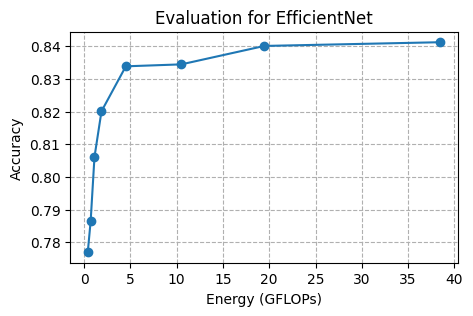

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(efficientnet_flops, efficientnet_accuracies, '-o')
plt.title("Evaluation for EfficientNet")
plt.xlabel("Energy (GFLOPs)")
plt.ylabel("Accuracy")
plt.grid(linestyle='--')
plt.show()

## Evaluation metric

We remind that for every model proposed by the participants, the average energy consumption over the test set should be strictly less than $E_\max = 39.32$ GFLOPs - which is inspired from the average energy consumption of EfficientNet-B7.

The following function will be used to compute a final score, on the basis of which submissions will be ranked.

In [ ]:
def metric(Ens, Accs):
    e_max = 39.32
    AUC = 0
    Ens, Accs = zip(*sorted(zip(Ens, Accs)))
    Ens, Accs = list(Ens),list(Accs)
    Ens.append(e_max)
    for i in range(len(Ens)-1):
      AUC = AUC + Accs[i] * (Ens[i+1]-Ens[i])
    return AUC

For the sake of simplicity, we consider an example of a submission consisting in 3 models among the EfficientNet family. Precisely, we choose
- `efficientnet_b0`
- `efficientnet_b3`
- `efficientnet_b6`

The corresponding Energy v.s. Accuracy curve is given below.

<!-- 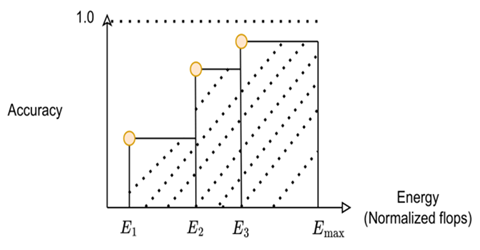
-->

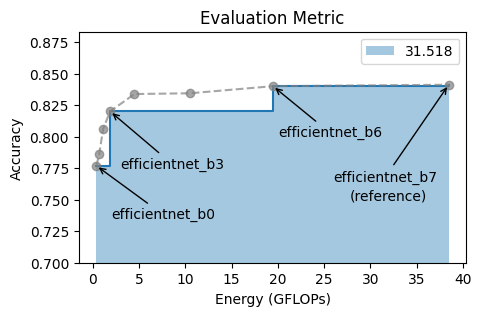

In [ ]:
Ens = [ efficientnet_flops[0], efficientnet_flops[3], efficientnet_flops[6], 39.32 ]
Accs = [ efficientnet_accuracies[0], efficientnet_accuracies[3], efficientnet_accuracies[6], 39.32 ]

# Compute the challenge score
score = metric(Ens, Accs)

# Visualization
plt.figure(figsize=(5,3))
plt.title("Evaluation Metric")
plt.step(Ens, Accs, where='post')
plt.fill_between(Ens, Accs, step="post", alpha=0.4, label=f'{round(score,3)}')
plt.plot(efficientnet_flops, efficientnet_accuracies, 'o--', color='grey', alpha=0.7)


plt.annotate('efficientnet_b0', xy=(Ens[0], Accs[0]), xytext=(2, 0.735),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
)

plt.annotate('efficientnet_b3', xy=(Ens[1], Accs[1]), xytext=(3, 0.775),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
)

plt.annotate('efficientnet_b6', xy=(Ens[2], Accs[2]), xytext=(20, 0.8),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
)

plt.annotate('efficientnet_b7', xy=(Ens[3], Accs[3]), xytext=(26, 0.765),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
)

plt.annotate('(reference)', xy=(Ens[3], Accs[3]), xytext=(27.8, 0.75),
)

plt.ylim(0.7)
plt.xlabel("Energy (GFLOPs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()